<h1 style="text-align: center; font-weight: bold; text-decoration: underline; text-decoration-color: red;">
    Projet SIGMA M2 : TELEA
</h1>


**Auteur :** Martin Axel


**Objectif :** Le but de ce projet est d’exploiter une série temporelle d’images Sentinel-2 pour analyser et caractériser les strates de végétation et les types de sols (notamment les landes) dans une zone d’étude.
 
Cela implique d’implémenter une chaîne de traitement en Python comprenant l’analyse des échantillons obtenus par photo-interprétation, l’extraction d’indices spectraux pertinents, la réalisation de visualisations statistiques, ainsi que la production et l’évaluation d’une carte de strates à l’aide de méthodes de classification supervisée

### **Importation des bibliothèques nécessaire au projet :**

In [63]:
import os
import sys
from osgeo import gdal
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.metrics import confusion_matrix, classification_report
sys.path.insert(0, "/home/onyxia/work/")
import my_function as my
from libsigma import read_and_write as rw
from libsigma import classification as cla
from libsigma import plots


### **4.2 Analyse des échantillons** 

#### **4.2.1 Nombre d’échantillons** 

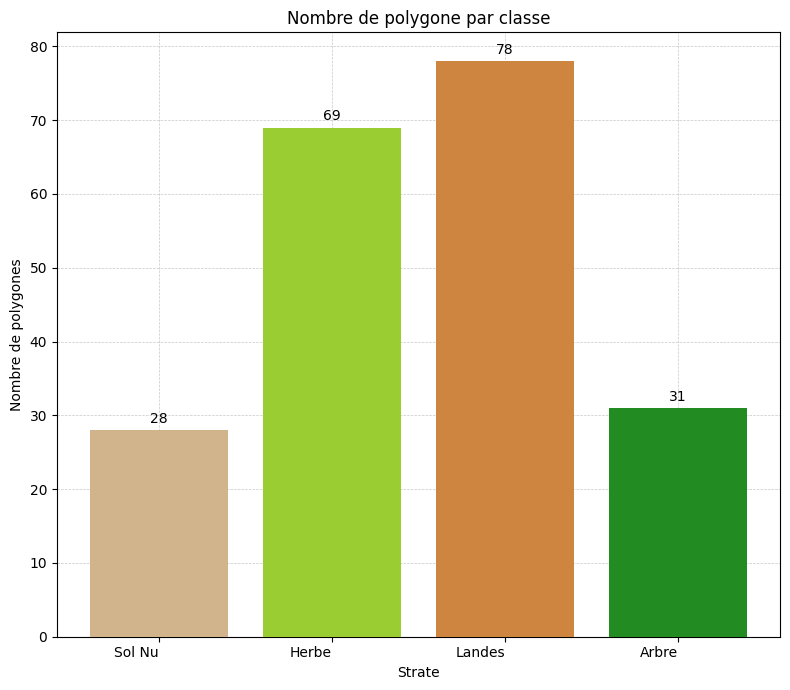

gdal_rasterize -at -a strate -tr 10.0 10.0 -te 684590.0 4744830.0 705620.0 4761380.0 -a_nodata 0 -ot Int32 -of GTiff "/home/onyxia/work/data/projet_eval/PI_strates_pyrenees_32630.shp" "/home/onyxia/work/results/samples_raster.tif"
0...10...20...30...40...50...60...70...80...90...100 - done.
Comptage des pixels par classe :
Valeur 1 -> 132 pixels
Valeur 2 -> 313 pixels
Valeur 3 -> 364 pixels
Valeur 4 -> 141 pixels


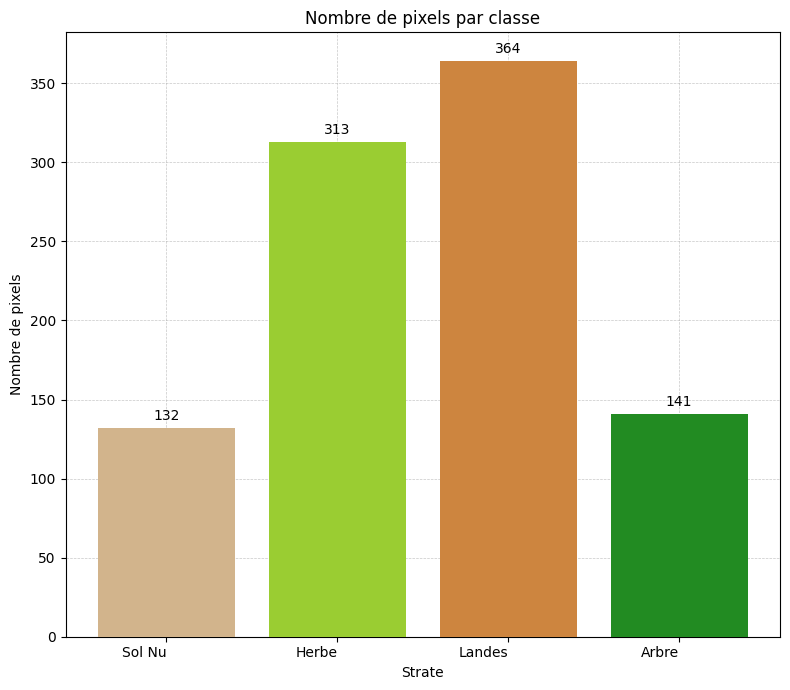

In [64]:
import os
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import my_function as my
from libsigma import read_and_write as rw

# --- Chemins et fichiers ---
ts_path = '/home/onyxia/work/data/projet_eval'
in_vector = os.path.join(ts_path, "PI_strates_pyrenees_32630.shp")
ref_image = os.path.join(ts_path, "pyrenees_23-24_B02.tif")
samples_raster = '/home/onyxia/work/results/samples_raster.tif'
strat = "strate"
os.makedirs("/home/onyxia/work/results/figure", exist_ok=True)
dir_fig = "/home/onyxia/work/results/figure"

# --- Lecture des données ---
sample_data = gpd.read_file(in_vector)

# Comptage des polygones par strate
counts_label = sample_data.groupby("strate").size()

# Couleurs et noms des strates
colors = ["tan", "yellowgreen", "peru", "forestgreen"]
names = {1: "Sol Nu", 2: "Herbe", 3: "Landes", 4: "Arbre"}

# --- 1) Barplot du nombre de polygones ---
fig, ax = plt.subplots(figsize=(8,7))
bars = ax.bar(counts_label.index.astype(int), counts_label.values, color=colors, zorder=3)

# Nom des strates en x
ax.set_xticks(counts_label.index.astype(int))
ax.set_xticklabels([names.get(i, str(i)) for i in counts_label.index.astype(int)], rotation=0, ha='right')

# Valeurs au-dessus des barres
for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{int(height)}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom',
                zorder=4)

ax.set_title("Nombre de polygone par classe")
ax.set_xlabel("Strate")
ax.set_ylabel("Nombre de polygones")

# Grille derrière les barres
ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7, zorder=0)

plt.tight_layout()
plt.show()
fig.savefig(os.path.join(dir_fig, "diag_baton_nb_poly_by_class.png"), dpi=300, bbox_inches='tight')

# --- Rasterisation ---
my.rasterisation(in_vector, ref_image, samples_raster, strat, dtype="Int32")

# --- Lecture du raster des strates ---
arr3d = rw.load_img_as_array(samples_raster, verbose=False)
arr = arr3d[:, :, 0]  # on prend la première bande

# enlever le fond (0)
vals = arr[arr != 0]
values, counts = np.unique(vals, return_counts=True)

print("Comptage des pixels par classe :")
for v, c in zip(values, counts):
    print(f"Valeur {int(v)} -> {int(c)} pixels")


# --- 2) Barplot du nombre de pixels ---
fig, ax = plt.subplots(figsize=(8,7))
bars = ax.bar(values.astype(int), counts, color=colors[:len(values)], zorder=3)

# Nom des strates en x
ax.set_xticks(values.astype(int))
ax.set_xticklabels([names.get(v, str(v)) for v in values.astype(int)], rotation=0, ha='right')

# Valeurs au-dessus des barres
for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{int(height)}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, max(counts)*0.01),
                textcoords="offset points",
                ha='center', va='bottom',
                zorder=4)

ax.set_title("Nombre de pixels par classe")
ax.set_xlabel("Strate")
ax.set_ylabel("Nombre de pixels")

# Grille derrière les barres
ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7, zorder=0)

plt.tight_layout()
plt.show()
# Exemple après avoir créé ton graphique
fig.savefig(os.path.join(dir_fig, "diag_baton_nb_pix_by_class.png"), dpi=300, bbox_inches='tight')



#### **4.2.2 Phénologie des strates, mise en évidence des landes**

#### **Création du raster d'ARI**

In [65]:
data_type_match = {'uint8': gdal.GDT_Byte,
                   'uint16': gdal.GDT_UInt16,
                   'uint32': gdal.GDT_UInt32,
                   'int16': gdal.GDT_Int16,
                   'int32': gdal.GDT_Int32,
                   'float32': gdal.GDT_Float32,
                   'float64': gdal.GDT_Float64}

# define parameters
dirname = '/home/onyxia/work/data/projet_eval'
out_dirname = '/home/onyxia/work/results'
dir_B3 = os.path.join(dirname, 'pyrenees_23-24_B03.tif')
dir_B5 =  os.path.join(dirname, 'pyrenees_23-24_B05.tif')
out_ari_filename = os.path.join(out_dirname, 'ARI_serie_temp.tif')

# load data
data_set_B3 = rw.open_image(dir_B3)
img_B3 = rw.load_img_as_array(dir_B3)
data_set_B5 = rw.open_image(dir_B5)
img_B5 = rw.load_img_as_array(dir_B5)

# do some processingwith numpy: compute ndvi
B3 = img_B3[:,:,:].astype('float32')
B5 = img_B5[:,:,:].astype('float32')

ari = my.compute_ari_timeseries(B3, B5)

rw.write_image(out_ari_filename, ari, data_set=data_set_B5,
               gdal_dtype=data_type_match['float32'], projection=None)


ds = gdal.Open(out_ari_filename, gdal.GA_Update)
band = ds.GetRasterBand(1)
band.SetNoDataValue(-9999)  
band.FlushCache()
ds = None

ARI stats: min = -0.969209 max = 0.880237 mean = 0.110966586


#### **Création du graphique de série temporelle moyenne d’ARI de chaque strate**

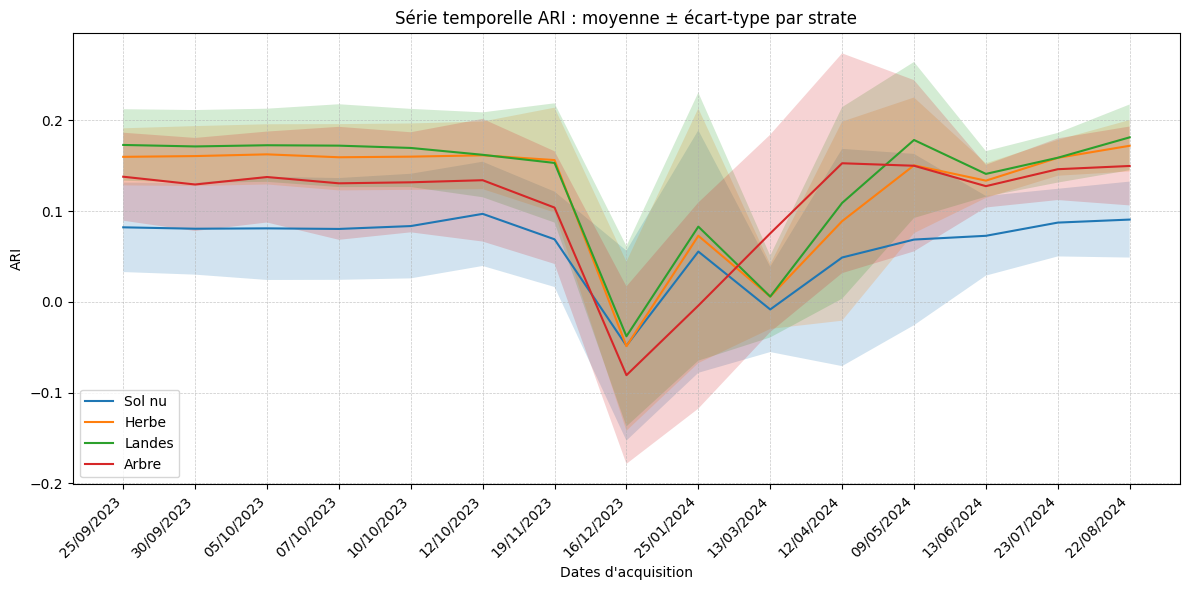

In [72]:
# Tes dates dans l'ordre
dates = [
    "25/09/2023", "30/09/2023", "05/10/2023", "07/10/2023", "10/10/2023",
    "12/10/2023", "19/11/2023", "16/12/2023", "25/01/2024", "13/03/2024",
    "12/04/2024", "09/05/2024", "13/06/2024", "23/07/2024", "22/08/2024"
]

# Extraction des pixels ARI par strate (ROI raster)
dict_X, dict_Y, dict_t = cla.get_samples_from_roi(
    out_ari_filename,       # ton ARI multi-bandes (15 temporalités)
    samples_raster,         # raster des strates (1..4)
    output_fmt="by_label"
)

names = {1:"Sol nu", 2:"Herbe", 3:"Landes", 4:"Arbre"}

fig, ax = plt.subplots(figsize=(12, 6))

n_dates = dict_X[list(dict_X.keys())[0]].shape[1]
x = np.arange(n_dates)

for lab in sorted(dict_X.keys()):   # lab = 1,2,3,4
    X = dict_X[lab]                 # (nb_pixels_de_la_strate, nb_dates)

    # Remplacer NoData par NaN
    X = np.where(X == -9999, np.nan, X)

    mean = np.nanmean(X, axis=0)
    std  = np.nanstd(X, axis=0)

    ax.plot(x, mean, label=names.get(lab, f"Strate {lab}"))
    ax.fill_between(x, mean - std, mean + std, alpha=0.2)

# Mise en forme des axes
ax.set_xlabel("Dates d'acquisition")
ax.set_ylabel("ARI")
ax.set_title("Série temporelle ARI : moyenne ± écart-type par strate")

# Remplacer les ticks en x par les dates
ax.set_xticks(x)
ax.set_xticklabels(dates, rotation=45, ha='right')

# Ajouter une grille
ax.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

ax.legend()
plt.tight_layout()
plt.show()
fig.savefig(os.path.join(dir_fig, "ARI_series.png"), dpi=300, bbox_inches='tight')



### **4.3 Production d’une carte de strates à l’échelle du pixel**

#### **4.3.2 Stratégie de validation (GridSearchCV)** ###

In [67]:
X, Y, t = cla.get_samples_from_roi(out_ari_filename, samples_raster)

# split samples
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3)

# Définition du modèle et de la grille d'hyperparamètres

rf = RF(random_state=0)

param_grid = {
    "n_estimators": [50, 100, 150, 200, 300],    # nombre d'arbres
    "max_depth": [None, 10, 15, 20],        # profondeur maximale des arbres (None = arbre entièrement développé)
    "max_features": [None,"sqrt", "log2"],  # nombre de variables testées à chaque split (valeurs plus faibles → plus les arbres sont différents → meilleure diversité)
    "min_samples_leaf": [1, 5],     # nombre minimal d’échantillons dans une feuille (valeurs plus grandes → arbres plus simples → moins d’overfitting)
    }

# Cross-validation stratifiée (conserve proportion des classes)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

# Grille de recherche
grid = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=cv,
    scoring="accuracy",
    n_jobs=-1  # utilise tous les CPU pour aller plus vite
)

# Entraînement avec recherche des meilleurs hyperparamètres 
grid.fit(X_train, Y_train)

print("Meilleurs hyperparamètres trouvés :")
print(grid.best_params_)

# Score moyen CV
print(f"Score CV moyen : {grid.best_score_:.2f}")

# Modèle final (entraîné sur tout le train) 
best_model = grid.best_estimator_

# Evaluation sur le test
Y_pred = best_model.predict(X_test)
acc_test = accuracy_score(Y_test, Y_pred)

print(f"Accuracy test : {acc_test:.2f}")


/opt/python/lib/python3.13/site-packages/sklearn/base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/python/lib/python3.13/site-packages/sklearn/base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/python/lib/python3.13/site-packages/sklearn/base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/python/lib/python3.13/site-packages/sklearn/base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example

Meilleurs hyperparamètres trouvés :
{'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 50}
Score CV moyen : 0.72
Accuracy test : 0.72


/opt/python/lib/python3.13/site-packages/sklearn/base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


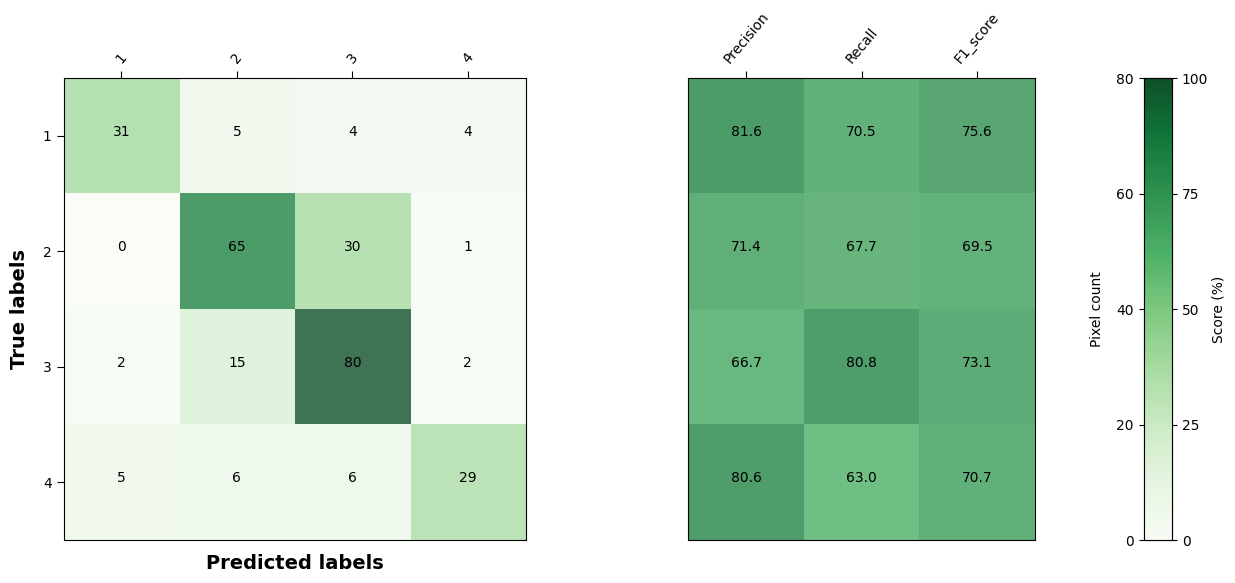

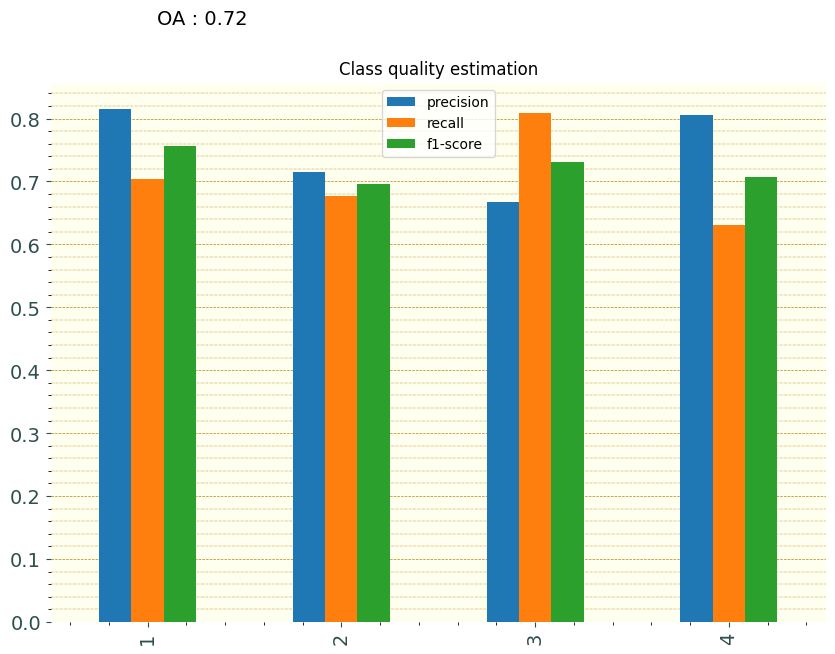

In [68]:
y_pred = best_model.predict(X_test)
acc_test = accuracy_score(Y_test, y_pred)

cm = confusion_matrix(Y_test, y_pred)
report = classification_report(Y_test, y_pred, labels=np.unique(Y_test),
output_dict=True)


# display and save quality
plots.plot_cm(cm, np.unique(Y_test))
plots.plot_class_quality(report, acc_test)

#### **4.3.3 Contribution des variables**

,Variable,Importance
0,25/09/2023,0.064941
1,30/09/2023,0.086582
2,05/10/2023,0.071317
3,07/10/2023,0.062403
4,10/10/2023,0.042415
5,12/10/2023,0.059444
6,19/11/2023,0.068896
7,16/12/2023,0.048497
8,25/01/2024,0.057120
9,13/03/2024,0.096279


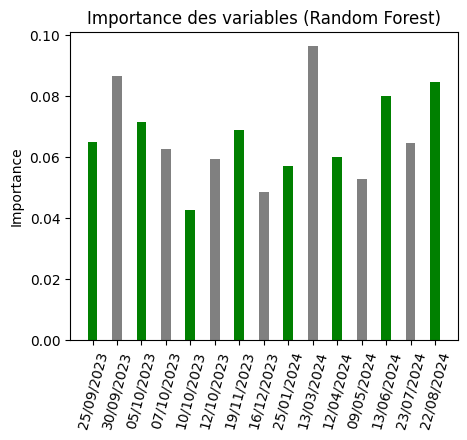

In [69]:
# Importance des variables
importances = best_model.feature_importances_
feature_names = [
    "25/09/2023",
    "30/09/2023",
    "05/10/2023",
    "07/10/2023",
    "10/10/2023",
    "12/10/2023",
    "19/11/2023",
    "16/12/2023",
    "25/01/2024",
    "13/03/2024",
    "12/04/2024",
    "09/05/2024",
    "13/06/2024",
    "23/07/2024",
    "22/08/2024"
]


# DataFrame pour affichage tabulaire
df_imp = pd.DataFrame({
    "Variable": feature_names,
    "Importance": importances
})
display(df_imp)

# Barplot des importances
plt.figure(figsize=(5, 4))
plt.bar(feature_names, importances, color=["green", "gray"], width=0.4)
plt.title("Importance des variables (Random Forest)")
plt.ylabel("Importance")
plt.xticks(rotation=75)
plt.show()

#### **4.3.4 Production de la carte finale**

In [70]:
# 5 --- apply on the whole image
# load image

out_classif = '/home/onyxia/work/results/carte_strates.tif'

X_img, _, t_img = cla.get_samples_from_roi(ref_image, ref_image)

Y_predict = best_model.predict(X_img)

# reshape
ds = rw.open_image(ref_image)
nb_row, nb_col, _ = rw.get_image_dimension(ds)

img = np.zeros((nb_row, nb_col, 1), dtype='uint8')
img[t_img[0], t_img[1], 0] = Y_predict

# write image
ds = rw.open_image(ref_image)
print("out_classif =", out_classif)
rw.write_image(out_classif, img, data_set=ds, gdal_dtype=data_type_match['uint8'],
            transform=None, projection=None, driver_name=None,
            nb_col=None, nb_ligne=None, nb_band=1)
band = ds.GetRasterBand(1)
band.SetNoDataValue(0)  
band.FlushCache()
ds = None         

/home/onyxia/work/libsigma/classification.py:101: RuntimeWarning: invalid value encountered in cast
  Y = ROI[t].reshape((t[0].shape[0], 1)).astype('int32')


out_classif = /home/onyxia/work/results/carte_strates.tif


#### **4.3.5 Analyse des résultats**